In [17]:
from collections import defaultdict
from collections import Counter
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [18]:
corpus = pd.read_csv('twistytest.csv', 
                     index_col=0, 
                     header=1, 
                     names=['user_id', 'lang', 'text', 'mbti'])
corpus.head()

,user_id,lang,text,mbti
1,352956832,it,['Feeling cranky and very little inclined to s...,ISTP
2,301484731,it,"['@Sgrattia o dormire morendo', 'i dipendenti ...",INTP
3,163103634,it,"['Facebook full of viruses, hackers and bullsh...",INTJ
4,629069123,it,"['@F_Molinari complimenti,il mio gatto patta m...",INFP
5,875579587,it,"['E infine: https://t.co/3Lpt72bnet', ""Sbaglio...",INTJ


In [19]:
#for name1, g1 in corpus.groupby('mbti'):
#    for name2, g2 in g1.groupby('lang'):
#        print(name1, name2, g1.shape, g2.shape)
mask = corpus['mbti'].isin(['ESFP', 'ESTP', 'ESFJ', 'ESTJ'])
corpus['mbti'] = corpus.mbti.apply(lambda x: x[0]) # trim annotation to I-E
print(corpus.head())
filtered = corpus[~mask].sample(frac=0.1)

X_train, X_test, y_train, y_test = train_test_split(filtered.text.tolist(), 
                                                    filtered.mbti.tolist(), 
                                                    test_size=0.2)

     user_id lang                                               text mbti
1  352956832   it  ['Feeling cranky and very little inclined to s...    I
2  301484731   it  ['@Sgrattia o dormire morendo', 'i dipendenti ...    I
3  163103634   it  ['Facebook full of viruses, hackers and bullsh...    I
4  629069123   it  ['@F_Molinari complimenti,il mio gatto patta m...    I
5  875579587   it  ['E infine: https://t.co/3Lpt72bnet', "Sbaglio...    I


In [20]:
y2i = defaultdict(lambda: len(y2i))
y_train_num = [y2i[mbti] for mbti in y_train]
y_test_num = [y2i[mbti] for mbti in y_test]
num_classes = len(np.unique(y_train_num))
y_train_one_hot = np_utils.to_categorical(y_train_num, num_classes) #important to give the num_classes!
y_test_one_hot = np_utils.to_categorical(y_test_num, num_classes) #important to give the num_classes!
print(num_classes)

2


In [21]:
c2i = defaultdict(lambda: len(c2i))
PAD = c2i["<"] # index 0 is padding
UNK = c2i["+"] # index 1 is for UNK

# convert words to indices, taking care of UNKs
X_train_num = [[c2i[char] for char in sentence] for sentence in X_train]
c2i = defaultdict(lambda: UNK, c2i) # freeze - cute trick!
X_test_num = [[c2i[char] for char in sentence] for sentence in X_test]

max_sentence_length=max([len(s.split(" ")) for s in X_train] 
                        + [len(s.split(" ")) for s in X_test] )
print(max_sentence_length)

44158


In [22]:
from keras.preprocessing import sequence
# pad X
X_train_pad = sequence.pad_sequences(X_train_num, maxlen=max_sentence_length, value=PAD)
X_test_pad = sequence.pad_sequences(X_test_num, maxlen=max_sentence_length,value=PAD)
print(X_train_pad.shape)

(68, 44158)


In [7]:
vocab_size = len(c2i)
embeds_size=64

In [13]:
np.random.seed(113) #set seed before any keras import
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, GRU

model = Sequential()
model.add(Embedding(vocab_size, embeds_size, input_length=max_sentence_length))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, go_backwards=True))
model.add(Dense(num_classes))
model.add(Activation('relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.fit(X_train_pad, y_train_one_hot, epochs=3, batch_size=2)
loss, accuracy = model.evaluate(X_test_pad, y_test_one_hot)

Epoch 1/3
68/68 [==============================] - 771s - loss: nan - acc: 0.8529    
Epoch 2/3
68/68 [==============================] - 717s - loss: nan - acc: 0.8529    
Epoch 3/3
18/18 [==============================] - 4s


In [15]:
print("Accuracy: ", accuracy *100)

Accuracy:  88.8888895512


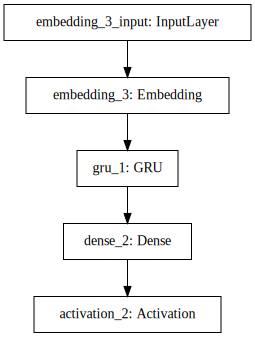

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# TODO

- run with 0.4 percent of dataset
- with bi-RNN